<a href="https://colab.research.google.com/github/kishore145/AI-ML-Foundations/blob/master/Neural%20Networks/08_NLP_using_dense_net_sentiment_classifier_and_roc_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies and Set hyper parameters

In [0]:
# Import dependencies
import tensorflow as tf

from tensorflow.keras.datasets import imdb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt


In [0]:
# Setting hyper parameters
output_dir = os.path.join('model_output', 'dense_1')

# training
epochs = 4
batch_size = 128

# vector space embedding
n_dim = 64              # All words will be represented as 64 long vectors
n_unique_words = 5000   # Limi the # of unique words in vocab to 5k top words
n_words_to_skip = 50    # Words that appears more than 50 times taken stopword.
max_review_length = 100 # Limit i/p len to 100 - dense n/w req fixed i/p size. 
# Padding to occur at begining of sentence in case length < 100
# Truncation to occur at end of sentence in case length > 100
pad_type = trunc_type = 'pre'   # Padd

# neural network architecture
n_dense = 64
dropout = 0.5



# Data loading & Preprocessing

For a given data set:

The Keras text utilities quickly preprocess natural language and convert it into an index.  
The keras.preprocessing.text.Tokenizer class may do everything you need in one line:  

        tokenize into words or characters
        num_words: maximum unique tokens
        filter out punctuation
        lower case
        convert words to an integer index

      tf.keras.datasets.imdb.load_data(
        path="imdb.npz",
        num_words=None,
        skip_top=0,
        maxlen=None,
        seed=113,
        start_char=1,
        oov_char=2,
        index_from=3,
        **kwargs
    )


In [0]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words,  
                                                        skip_top=n_words_to_skip)

In [4]:
# 0 reserved for padding; 
# 1 would be starting character; 
# 2 is unknown / oov-char; 
# 3 is most common word
# 4 is the second most common word, etc.

x_train[0:6] 

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

In [5]:
[len(x) for x in x_train[:6]]

[218, 189, 141, 550, 147, 43]

In [6]:
y_train[:6]

array([1, 0, 0, 1, 0, 0])

In [7]:
# The word index dictionary. Keys are word strings, values are their index.
word_index = tf.keras.datasets.imdb.get_word_index()
dict(list(word_index.items())[:5])

{'fawn': 34701,
 'nunnery': 52007,
 'sonja': 16816,
 'tsukino': 52006,
 'vani': 63951}

In [8]:
# Increasing index count by 3 for adding Pad, start and unknnown to index
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2
dict(list(word_index.items())[:5])

{'fawn': 34704,
 'nunnery': 52010,
 'sonja': 16819,
 'tsukino': 52009,
 'vani': 63954}

In [9]:
# reverse word_index for easy reference
word_index = {v:k for (k,v) in word_index.items()}
dict(list(word_index.items())[:5])

{16819: 'sonja',
 34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 63954: 'vani'}

In [10]:
# Review sample training data in human readable format
' '.join(word_index[i] for i in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [11]:
# Review original data to understand which words are replaced
(all_x_train,_),(all_x_valid,_) = imdb.load_data()
' '.join(word_index[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

In [0]:
x_train = pad_sequences(x_train, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, 
                        padding=pad_type, truncating=trunc_type, value=0)

In [13]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

In [14]:
# Review sample training data in human readable format
# As it's seen, padding and truncation happens from the begining of sentence.
for k in range(0,6):
  print(' '.join(word_index[i] for i in x_train[k]))

cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK
funny UNK equal UNK UNK hair UNK big lots UNK UNK UNK men wear those cut UNK UNK UNK show off their UNK UNK UNK men actually wore them UNK UNK music UNK UNK UNK trash UNK plays over UNK over again UNK almost every scene there UNK trashy music UNK UNK UNK taking away bodies UNK UNK UNK still doesn't close UNK UNK UNK UNK aside UNK UNK UNK truly bad UNK whose only charm UNK UNK look back UNK UNK disaster UNK UNK UNK 80's UNK UNK UNK good old laugh UNK how bad everything UNK back then
touching UNK floor UNK

In [15]:
[len(x) for x in x_train[:6]]

[100, 100, 100, 100, 100, 100]

# Neural Network section

In [0]:
# Design dense neural network
model = Sequential()

# Add embedding layer
# Turns positive integers (indexes) into dense vectors of fixed size.
# e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]
model.add(Embedding(input_dim=n_unique_words, 
                    output_dim=n_dim,
                    input_length = max_review_length))
# Flatten o/p from embedding layer to feed into dense layer
model.add(Flatten())

# Add first dense layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

# Add o/p layer activation is sigmoid as binary classifier
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                409664    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [18]:
# embedding layer dimensions and parameters: 
n_dim, n_unique_words, n_dim*n_unique_words

(64, 5000, 320000)

In [19]:
# ...flatten:
max_review_length, n_dim, n_dim*max_review_length

(100, 64, 6400)

In [20]:
# ...dense:
n_dense, n_dim*max_review_length*n_dense + n_dense # weights + biases

(64, 409664)

In [21]:
# ...and output:
n_dense + 1

65

In [0]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [0]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [0]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [25]:
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=epochs, verbose=1, 
          validation_data=(x_valid, y_valid), 
          callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 5s 25ms/step - loss: 0.5340 - accuracy: 0.7030 - val_loss: 0.3505 - val_accuracy: 0.8470
Epoch 2/4
196/196 [==============================] - 5s 24ms/step - loss: 0.2762 - accuracy: 0.8905 - val_loss: 0.3566 - val_accuracy: 0.8424
Epoch 3/4
196/196 [==============================] - 4s 23ms/step - loss: 0.1174 - accuracy: 0.9654 - val_loss: 0.4289 - val_accuracy: 0.8325
Epoch 4/4
196/196 [==============================] - 5s 23ms/step - loss: 0.0270 - accuracy: 0.9954 - val_loss: 0.5259 - val_accuracy: 0.8331


In [0]:
# Evaluate model - use the model with hightest val accuracy
model.load_weights(output_dir+"/weights.04.hdf5") # NOT zero-indexed

In [0]:
# Predict y_hat
y_hat = model.predict(x_valid)

In [28]:
len(y_hat)

25000

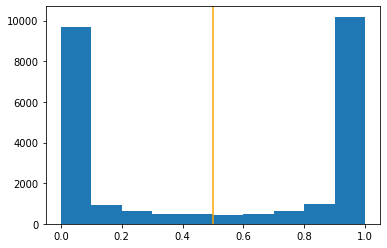

In [29]:
# Plot predictions
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [0]:
# Find AUC-ROC value
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [31]:
print("AUC-ROC Value: {:0.2f}".format(pct_auc))

AUC-ROC Value: 91.51


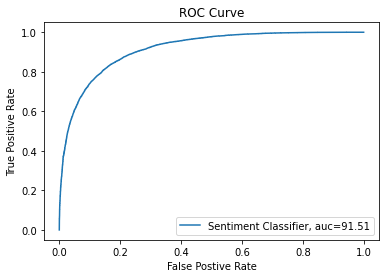

In [32]:
from sklearn import metrics
fpr, tpr, auc = metrics.roc_curve(y_valid,  y_hat)
plt.plot(fpr,tpr,label="Sentiment Classifier, auc="+"{:0.2f}".format(pct_auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [33]:
# To explain working of Embed layer more clearly
import numpy as np
input_array = np.random.randint(1000, size=(5, 3))
input_array

array([[543, 206, 853],
       [100, 521, 983],
       [770, 463, 457],
       [820, 287, 232],
       [335, 895, 874]])

In [34]:
# Creating a dummy model to show embed working
m = Sequential()
m.add(Embedding(1000, 2, input_length=3))
m.compile('rmsprop', 'mse')
output_array = m.predict(input_array)
print(output_array.shape)
output_array

(5, 3, 2)


array([[[-0.03651786,  0.02965679],
        [ 0.01314868,  0.03270027],
        [-0.00970981,  0.04420645]],

       [[-0.01318068, -0.0434765 ],
        [ 0.0173938 ,  0.0235307 ],
        [ 0.00517855,  0.04603093]],

       [[ 0.00390147,  0.02830623],
        [ 0.00708562, -0.02062752],
        [-0.02034268,  0.00695213]],

       [[-0.0160288 ,  0.0017153 ],
        [-0.00324367, -0.00400529],
        [ 0.00217571, -0.02929492]],

       [[-0.03361596, -0.02719327],
        [-0.03154149,  0.01090693],
        [-0.01839815, -0.00365236]]], dtype=float32)